# Reconocimiento por voz utilizando modelos de Markov ocultos

## Equipo 3 - Integrado por

Andrés Olvera \
Ernest Godínez \
Alejandro Hermosillo \
Mauricio Andrés Flores \
Ana Paula Ponce

## Importacion de librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import warnings
import logging

from librosa.feature import mfcc
from scipy.io import wavfile
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
%matplotlib inline
warnings.filterwarnings('ignore')
logging.getLogger("hmmlearn").setLevel("CRITICAL")

## Funciones necesarias

Función que se encarga de extraer las características del audio en forma de de un espectro de potencia de un sonido. Esta función devuelve dichas características en forma de matriz

In [ ]:
def extract_mfcc(full_audio_path):
  data, sample_rate = librosa.load(full_audio_path)
  mfcc_features = mfcc(data, sample_rate)
  return mfcc_features

Función que crea un dataset recibiendo las urls de los archivos y a que categoría pertenece cada url. Categoría se refiere a que palabra se dice en el audio. Esta función devuelve un diccionario en donde la llave es la palabra que se dijo en el audio y el valor es la matriz de características que se extrajo de la función extract_mfcc

In [ ]:
def buildDataSet(urls, labels):
  dataset = {}

  for i in range(len(urls)):
    label = labels[i]
    url = urls[i]
    features = extract_mfcc(url)[:, :12]
    if label not in dataset.keys():
      dataset[label] = []
      dataset[label].append(features)
    else:
      exist_feature = dataset[label]
      exist_feature.append(features)
      dataset[label] = exist_feature
  return dataset

Función que entrena un modelo oculto de Markov utilizando un modelo de mezclas gaussianas. Para esto, se hace uso de la librería hmmlearn. Esta librería necesita de los componentes principales para un modelo oculto de Markov, como lo son el número de estados a utilizar, la matriz de transición inicial, la probabilidad inicial de los estados y el tipo de covarianza que se utilizará. La función se encarga de encontrar los mejores párametros en el modelo oculto de Markov que logren replicar las observaciones dadas en los datos de entrenamiento. Al final, genera un modelo oculto de Markov distinto para cada palabra del conjunto de entrenamiento. 

In [ ]:
def train_GMMHMM(dataset):
  GMMHMM_Models = {}
  states_num = 5
  GMM_mix_num = 3
  tmp_p = 1.0/(states_num-2)
  transmatPrior = np.array([[tmp_p, tmp_p, tmp_p, 0, 0],
                            [0, tmp_p, tmp_p, tmp_p, 0],
                            [0, 0, tmp_p, tmp_p, tmp_p],
                            [0, 0, 0, 0.5, 0.5],
                            [0, 0, 0, 0, 1]], dtype = np.float)
  
  startprobPrior = np.array([0.5, 0.5, 0, 0, 0], dtype = np.float)

  for label in dataset.keys():
    model = hmm.GMMHMM(n_components = states_num, n_mix = GMM_mix_num, transmat_prior = transmatPrior, startprob_prior =  startprobPrior, covariance_type = 'diag', n_iter = 10)
    trainData = dataset[label]
    length = np.zeros([len(trainData), ], dtype = np.int)
    for m in range(len(trainData)):
      length[m] = trainData[m].shape[0]
    trainData = np.vstack(trainData)
    model.fit(trainData, lengths = length)
    GMMHMM_Models[label] = model
    
  return GMMHMM_Models

## Generacion de conjunto de prueba y de entrenamiento

Se utiliza un conjunto de entrenamiento, el cual contiene el 80% de los datos totales, mientras que se utiliza un conjunto de prueba con un 20% de los datos totales. Estos datos se toman de forma aleatorio para obtener los mejores resultados. 

In [ ]:
url_audio = '/content/drive/Shareddrives/Analisis Incertidumbre (PEDRO)/PBL3/Audio'

urls = []
labels = []

for file in os.listdir(url_audio):
    for word in os.listdir(url_audio + '/' + file):
      urls.append(url_audio+'/'+file+'/'+word)
      labels.append(file)

X_train, X_test, y_train, y_test = train_test_split(urls, labels, test_size = 0.2)

dataset_train = buildDataSet(X_train, y_train)
dataset_test = buildDataSet(X_test, y_test)

## Creación del modelo

Para crear los modelos ocultos de Markov, solo es necesario llamar a la función train_GMMHMM con el conjunto de datos de entrenamiento. 

In [ ]:
hmmModels = train_GMMHMM(dataset_train)

## Evaluación del modelo

Para evaluar el modelo, se utilizarán los datos de prueba. La forma de evaluación es muy simple, para cada dato de prueba, se obtiene cual es la probabilidad de que ese conjunto de observaciones sean explicados dado ese modelo. El modelo que tenga una mayor probabilidad, es decir, que las observaciones concuerden mejor con dicho modelo, será el elegido como la predicción final. Finalmente realizamos un conteo de los valores correctos y obtenemos cual es la exactitud del modelo. 

Test en valor verdadero  lime : resultado predecido es  lime
Test en valor verdadero  lime : resultado predecido es  lime
Test en valor verdadero  lime : resultado predecido es  lime
Test en valor verdadero  lime : resultado predecido es  lime
Test en valor verdadero  lime : resultado predecido es  lime
Test en valor verdadero  peach : resultado predecido es  peach
Test en valor verdadero  pineapple : resultado predecido es  pineapple
Test en valor verdadero  pineapple : resultado predecido es  pineapple
Test en valor verdadero  apple : resultado predecido es  apple
Test en valor verdadero  apple : resultado predecido es  apple
Test en valor verdadero  apple : resultado predecido es  apple
Test en valor verdadero  apple : resultado predecido es  apple
Test en valor verdadero  apple : resultado predecido es  apple
Test en valor verdadero  apple : resultado predecido es  apple
Test en valor verdadero  apple : resultado predecido es  apple
Test en valor verdadero  apple : resultado predec

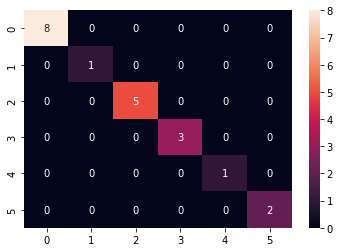

In [ ]:
valores_reales = []
valores_pred = []

score_cnt = 0
for label in dataset_test.keys():
  for feature in dataset_test[label]:
    scoreList = {}
    for model_label in hmmModels.keys():
      model = hmmModels[model_label]
      score = model.score(feature)
      scoreList[model_label] = score
    predict = max(scoreList, key=scoreList.get)
    valores_reales.append(label)
    valores_pred.append(predict)
    print("Test en valor verdadero ", label, ": resultado predecido es ", predict)
    if predict == label:
        score_cnt+=1
print("Precisión final del modelo es %.2f"%(100.0*score_cnt/len(y_test)), "%")

import seaborn as sns
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(valores_reales, valores_pred)
sns.heatmap(matrix, annot=True)